In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC

from src.data_prep import shuffle_fighters, win_method_binner, pivot_longer, calculate_running_totals

pd.set_option('display.max_columns', None)

In [2]:
event_details = pd.read_csv('https://github.com/SamEdwardes/ufc-data/raw/master/event_details.csv')
event_details['date'] = pd.to_datetime(event_details['date'])
fighter_details = pd.read_csv('https://github.com/SamEdwardes/ufc-data/raw/master/fighter_details.csv')

clean data

In [3]:
df = shuffle_fighters(event_details)
df['win_method_bin'] = df['win_method'].apply(win_method_binner)
df_long = pivot_longer(df)
df_long = calculate_running_totals(df_long)
df_long = pd.merge(
    df_long, 
    fighter_details[['fighter_url', 'height_inches', 'weight_lbs', 'reach_inches', 'stance']], 
    how='left',
    left_on='fighter_url', right_on='fighter_url'
)
features_to_merge = [
    'fight_id', 'num_fights', 'wins', 'losses', 'days_since_last_fight', 
    'total_tko_recieved', 'total_octagon_time',
    'last_fight_time', 'last_fight_tko_received', 'last_fight_win',
    'last_fight_loss', 'height_inches', 'weight_lbs', 'reach_inches',
    'stance'
]

X = pd.merge(
    df,
    df_long.query('colour == "blue"')[features_to_merge].add_prefix('blue_'),
    left_on = 'fight_id',
    right_on = 'blue_fight_id'
)

X = pd.merge(
    X,
    df_long.query('colour == "red"')[features_to_merge].add_prefix('red_'),
    left_on = 'fight_id',
    right_on = 'red_fight_id'
)

X = X.drop(columns=['blue_fight_id', 'red_fight_id'])
y = X['blue_win'].ravel()
X = X.drop(columns=['blue_win'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1993)

In [4]:
X_train

,event_name,date,weight_class,win_method,win_round,win_time,fight_url,fight_id,blue,red,winner_colour,blue_url,red_url,winner_name,blue_str,red_str,blue_td,red_td,blue_sub,red_sub,blue_pass,red_pass,win_method_bin,blue_num_fights,blue_wins,blue_losses,blue_days_since_last_fight,blue_total_tko_recieved,blue_total_octagon_time,blue_last_fight_time,blue_last_fight_tko_received,blue_last_fight_win,blue_last_fight_loss,blue_height_inches,blue_weight_lbs,blue_reach_inches,blue_stance,red_num_fights,red_wins,red_losses,red_days_since_last_fight,red_total_tko_recieved,red_total_octagon_time,red_last_fight_time,red_last_fight_tko_received,red_last_fight_win,red_last_fight_loss,red_height_inches,red_weight_lbs,red_reach_inches,red_stance
4187,UFC_116-Lesnar_vs_Carwin,2010-07-03,Middleweight,"SUB, Triangle, Choke",3,4:40,http://www.ufcstats.com/fight-details/049659c5...,4187,Yoshihiro Akiyama,Chris Leben,red,http://www.ufcstats.com/fighter-details/b05500...,http://www.ufcstats.com/fighter-details/d43a04...,Chris Leben,27.0,46.0,5.0,0.0,1.0,4.0,4.0,0.0,SUB,1,1,0,357.0,0,15.000000,15.000000,0,1,0,70.0,170.0,73.0,Orthodox,15,10,5,14.0,1,130.433333,9.016667,0,1,0,71.0,185.0,74.0,Southpaw
4794,UFC_75-Champion_vs_Champion,2007-09-08,Light Heavyweight,U-DEC,5,5:00,http://www.ufcstats.com/fight-details/49458279...,4794,Dan Henderson,Rampage Jackson,red,http://www.ufcstats.com/fighter-details/1ccf4e...,http://www.ufcstats.com/fighter-details/ffc088...,Rampage Jackson,60.0,74.0,3.0,2.0,3.0,0.0,3.0,7.0,DEC,2,2,0,3403.0,0,16.000000,8.000000,0,1,0,71.0,185.0,74.0,Orthodox,2,2,0,105.0,0,9.150000,1.083333,0,1,0,73.0,205.0,73.0,Orthodox
5275,UFC_35-Throwdown,2002-01-11,Middleweight,"KO/TKO, Punch",2,0:44,http://www.ufcstats.com/fight-details/cfa9bc77...,5275,Murilo Bustamante,Dave Menne,blue,http://www.ufcstats.com/fighter-details/85d905...,http://www.ufcstats.com/fighter-details/275caf...,Murilo Bustamante,9.0,14.0,2.0,0.0,0.0,0.0,1.0,0.0,TKO,2,1,1,105.0,0,20.050000,15.000000,0,0,1,74.0,183.0,NaN,Orthodox,2,2,0,105.0,0,40.000000,25.000000,0,1,0,70.0,170.0,NaN,Orthodox
3387,UFC_on_FUEL_TV-Barao_vs_McDonald,2013-02-16,Welterweight,U-DEC,3,5:00,http://www.ufcstats.com/fight-details/7549887b...,3387,Jorge Santiago,Gunnar Nelson,red,http://www.ufcstats.com/fighter-details/f8dc54...,http://www.ufcstats.com/fighter-details/fd5539...,Gunnar Nelson,43.0,42.0,0.0,2.0,0.0,0.0,0.0,3.0,DEC,5,1,4,497.0,3,43.166667,15.000000,0,0,1,73.0,170.0,74.0,Orthodox,1,1,0,140.0,0,3.050000,3.050000,0,1,0,71.0,170.0,72.0,Switch
503,UFC_Fight_Night-Overeem_vs_Oleinik,2019-04-20,Heavyweight,"KO/TKO, Punches",2,3:15,http://www.ufcstats.com/fight-details/0bc7e485...,503,Marcin Tybura,Shamil Abdurakhimov,red,http://www.ufcstats.com/fighter-details/c9cf75...,http://www.ufcstats.com/fighter-details/2f5cbe...,Shamil Abdurakhimov,28.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,TKO,7,4,3,272.0,1,100.216667,15.000000,0,1,0,75.0,249.0,78.0,Orthodox,6,4,2,217.0,2,68.183333,15.000000,0,1,0,75.0,235.0,76.0,Orthodox
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,UFC_Fight_Night-Shevchenko_vs_Carmouche_2,2019-08-10,Featherweight,S-DEC,3,5:00,http://www.ufcstats.com/fight-details/4dd30354...,329,Enrique Barzola,Bobby Moffett,blue,http://www.ufcstats.com/fighter-details/be0b31...,http://www.ufcstats.com/fighter-details/d76ad9...,Enrique Barzola,83.0,90.0,3.0,0.0,0.0,0.0,0.0,0.0,DEC,7,5,2,133.0,0,105.000000,15.000000,0,0,1,67.0,145.0,70.0,Orthodox,2,1,1,140.0,0,22.066667,15.000000,0,0,1,70.0,145.0,73.0,Orthodox
349,UFC_240-Holloway_vs_Edgar,2019-07-27,Featherweight,U-DEC,5,5:00,http://www.ufcstats.com/fight-details/c4704eab...,349,Max Holloway,Frankie Edgar,blue,http://www.ufcstats.com/fighter-details/150ff4...,http://www.ufcstats.com/fighter-details/f26884...,Max Holloway,129.0,96.0,0.0,1.0,0.0,0.0,0.0,0.0,DEC,20,16,4,105.0,0,254.583333,25.000000,0,0

preprocess data

In [5]:
cat_cols = [
    'blue_stance', 'red_stance'
]

bool_cols = [
    'blue_last_fight_time', 'red_last_fight_time',
    'blue_last_fight_tko_received', 'red_last_fight_tko_received',
    'blue_last_fight_win', 'red_last_fight_win',
    'blue_last_fight_loss', 'red_last_fight_loss',
    
]

num_cols = [
    'blue_str', 'red_str', 
    'blue_td', 'red_td', 
    'blue_sub', 'red_sub', 
    'blue_pass', 'red_pass',
    'blue_num_fights', 'red_num_fights',
    'blue_wins', 'red_wins',
    'blue_losses', 'red_losses',
    'blue_days_since_last_fight', 'red_days_since_last_fight',
    'blue_total_tko_recieved', 'red_total_tko_recieved',
    'blue_total_octagon_time', 'red_total_octagon_time',
    'blue_height_inches', 'red_height_inches',
    'blue_weight_lbs', 'red_weight_lbs',
    'blue_reach_inches', 'red_reach_inches',
]

In [6]:
X_train[cat_cols + bool_cols + num_cols]

,blue_stance,red_stance,blue_last_fight_time,red_last_fight_time,blue_last_fight_tko_received,red_last_fight_tko_received,blue_last_fight_win,red_last_fight_win,blue_last_fight_loss,red_last_fight_loss,blue_str,red_str,blue_td,red_td,blue_sub,red_sub,blue_pass,red_pass,blue_num_fights,red_num_fights,blue_wins,red_wins,blue_losses,red_losses,blue_days_since_last_fight,red_days_since_last_fight,blue_total_tko_recieved,red_total_tko_recieved,blue_total_octagon_time,red_total_octagon_time,blue_height_inches,red_height_inches,blue_weight_lbs,red_weight_lbs,blue_reach_inches,red_reach_inches
4187,Orthodox,Southpaw,15.000000,9.016667,0,0,1,1,0,0,27.0,46.0,5.0,0.0,1.0,4.0,4.0,0.0,1,15,1,10,0,5,357.0,14.0,0,1,15.000000,130.433333,70.0,71.0,170.0,185.0,73.0,74.0
4794,Orthodox,Orthodox,8.000000,1.083333,0,0,1,1,0,0,60.0,74.0,3.0,2.0,3.0,0.0,3.0,7.0,2,2,2,2,0,0,3403.0,105.0,0,0,16.000000,9.150000,71.0,73.0,185.0,205.0,74.0,73.0
5275,Orthodox,Orthodox,15.000000,25.000000,0,0,0,1,1,0,9.0,14.0,2.0,0.0,0.0,0.0,1.0,0.0,2,2,1,2,1,0,105.0,105.0,0,0,20.050000,40.000000,74.0,70.0,183.0,170.0,NaN,NaN
3387,Orthodox,Switch,15.000000,3.050000,0,0,0,1,1,0,43.0,42.0,0.0,2.0,0.0,0.0,0.0,3.0,5,1,1,1,4,0,497.0,140.0,3,0,43.166667,3.050000,73.0,71.0,170.0,170.0,74.0,72.0
503,Orthodox,Orthodox,15.000000,15.000000,0,0,1,1,0,0,28.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,7,6,4,4,3,2,272.0,217.0,1,2,100.216667,68.183333,75.0,75.0,249.0,235.0,78.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,Orthodox,Orthodox,15.000000,15.000000,0,0,0,0,1,1,83.0,90.0,3.0,0.0,0.0,0.0,0.0,0.0,7,2,5,1,2,1,133.0,140.0,0,0,105.000000,22.066667,67.0,70.0,145.0,145.0,70.0,73.0
349,Orthodox,Orthodox,25.000000,15.000000,0,0,0,1,1,0,129.0,96.0,0.0,1.0,0.0,0.0,0.0,0.0,20,24,16,18,4,6,105.0,462.0,0,1,254.583333,403.400000,71.0,66.0,145.0,145.0,69.0,68.0
5215,Orthodox,Orthodox,6.066667,0.000000,1,0,0,0,1,0,22.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,210.0,0.0,1,0,6.066667,0.000000,75.0,72.0,260.0,235.0,NaN,NaN
225,Orthodox,Orthodox,9.083333,0.000000,1,0,0,0,1,0,32.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,1,0,2,0,504.0,0.0,1,0,24.116667,0.000000,79.0,74.0,245.0,255.0,82.0,75.0


In [7]:
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(missing_values=np.NaN, strategy='mean')),
    ('standard_scaler', StandardScaler())    
])

categorical_transformer = Pipeline(steps=[
    ('impute_mode', SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

bool_transformer = Pipeline(steps=[
    ('impute_mode', SimpleImputer(missing_values=np.NaN, strategy='most_frequent'))
])


ct = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('bool', bool_transformer, bool_cols),
    ('cat', categorical_transformer, cat_cols)
])

In [8]:
pd.DataFrame(
    ct.fit_transform(X_train),
    columns = num_cols + bool_cols + list(ct.transformers_[2][1]['ohe'].get_feature_names())
)

,blue_str,red_str,blue_td,red_td,blue_sub,red_sub,blue_pass,red_pass,blue_num_fights,red_num_fights,blue_wins,red_wins,blue_losses,red_losses,blue_days_since_last_fight,red_days_since_last_fight,blue_total_tko_recieved,red_total_tko_recieved,blue_total_octagon_time,red_total_octagon_time,blue_height_inches,red_height_inches,blue_weight_lbs,red_weight_lbs,blue_reach_inches,red_reach_inches,blue_last_fight_time,red_last_fight_time,blue_last_fight_tko_received,red_last_fight_tko_received,blue_last_fight_win,red_last_fight_win,blue_last_fight_loss,red_last_fight_loss,x0_Open Stance,x0_Orthodox,x0_Sideways,x0_Southpaw,x0_Switch,x1_Open Stance,x1_Orthodox,x1_Sideways,x1_Southpaw,x1_Switch
0,-0.191827,0.468786,2.298750,-0.641188,0.661592,4.008468,1.368889,-0.559850,-0.730946,1.917678,-0.583971,1.899593,-0.856406,1.592729,0.876415,-0.704445,-0.567688,0.544471,-0.576034,1.426305,-0.146051,0.153080,-0.029218,0.381433,2.156096e-01,0.479976,15.000000,9.016667,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.945256,1.429988,1.126946,0.551981,2.961030,-0.488973,0.891813,2.961436,-0.540951,-0.531421,-0.311041,-0.303290,-0.856406,-0.834762,15.276689,-0.294054,-0.567688,-0.550833,-0.558761,-0.672492,0.147961,0.744858,0.394079,0.932505,4.735791e-01,0.219763,8.000000,1.083333,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.812054,-0.629731,0.541045,-0.641188,-0.488127,-0.488973,-0.062339,-0.559850,-0.540951,-0.531421,-0.583971,-0.303290,-0.354866,-0.834762,-0.314941,-0.294054,-0.567688,-0.550833,-0.488806,-0.138636,1.029998,-0.142809,0.337639,-0.031871,-3.665967e-15,0.000000,15.000000,25.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.359486,0.331471,-0.630758,0.551981,-0.488127,-0.488973,-0.539415,0.949272,0.029034,-0.719813,-0.583971,-0.578651,1.149756,-0.834762,1.538279,-0.136211,2.815762,-0.550833,-0.089511,-0.778052,0.735986,0.153080,-0.029218,-0.031871,4.735791e-01,-0.040451,15.000000,3.050000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.157370,0.125499,-0.630758,-0.641188,-0.488127,-0.488973,-0.539415,-0.559850,0.409024,0.222148,0.234820,0.247431,0.648215,0.136235,0.474568,0.211044,0.560129,1.639775,0.895913,0.349074,1.324010,1.336636,2.200148,1.759114,1.505457e+00,1.000402,15.000000,15.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4471,1.737769,1.979246,1.126946,-0.641188,-0.488127,-0.488973,-0.539415,-0.559850,0.409024,-0.531421,0.507751,-0.578651,0.146675,-0.349264,-0.182568,-0.136211,-0.567688,-0.550833,0.978536,-0.448970,-1.028087,-0.142809,-0.734714,-0.720712,-5.582988e-01,0.219763,15.000000,15.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4472,3.322794,2.185218,-0.630758,-0.044603,-0.488127,-0.488973,-0.539415,-0.559850,2.878959,3.613207,3.509987,4.102476,1.149756,2.078227,-0.314941,1.315944,-0.567688,0.544471,3.562289,6.149969,0.147961,-1.326365,-0.734714,-0.720712,-8.162682e-01,-1.081303,25.000000,15.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4473,-0.364112,-0.904360,-0.630758,-0.641188,-0.488127,-0.488973,-0.539415,-0.559850,-0.730946,-0.908205,-0.856902,-0.854011,-0.354866,-0.834762,0.181457,-0.767582,0.560129,-0.550833,-0.730340,-0.830832,1.324010,0.448969,2.510567,1.759114,-3.665967e-15,0.000000,6.066667,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4474,-0.019542,2.082232,-0.630758,-0.641188,-0.488127,-0.488973,-0.539415,-0.559850,-0.350956,-0.908205,-0.583971,-0.854011,0.146675,-0.834762,1.571372,-0.767582,0.560129,-0.550833,-0.418562,-0.830832,2.500058,1.040747,2.087269,2.310187,2.537335e+00,0.740189,9.083333,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

## Base Model

In [10]:
def dict_score():
    d = {'model': None,
         'params': None}
    return d

In [11]:
def fit_and_score(model, params=None, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    if params is None:
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        valid_score = model.score(X_test, y_test)
        out = model
    else:
        clf = GridSearchCV(model, params)
        clf.fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        valid_score = clf.score(X_test, y_test)
        out = clf
        
    return (model, train_score, valid_score)

Build and test a base model

In [43]:
models = defaultdict(dict_score)

models['logistic_regression_base']['model'] = LogisticRegression()
fit_and_score(models['logistic_regression_base']['model'], None)

/Users/samedwardes/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.840929401251117,
 0.8366071428571429)

### Test more models

In [70]:
models['logistic_regression']['model'] = LogisticRegression()
# models['logistic_regression']['params'] = {
#     'penalty': ["l1", "l2", "elasticnet", "none"],
#     'solver': ['liblinear', 'lbfgs', 'saga'],
#     'max_iter': [1000]
# }

models['svc']['model'] = LinearSVC()
# models['svc']['params'] = {
#     'penalty': ["l1", "l2"],
#     'C': [0.01, 0.1, 1, 10, 100, 1000]
# }

models['random_forest']['model'] = RandomForestClassifier()
# models['random_forest']['params'] = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 5, 10, 20, 50],
#     'max_features': ["Auto", None, 2, 10, 20]
# }

models['ada_boost']['model'] = AdaBoostClassifier()
models['gradient_boost']['model'] = GradientBoostingClassifier()
models['knn']['model'] = KNeighborsClassifier()
models['neural_network']['model'] = MLPClassifier(hidden_layer_sizes=(100, 50, 10), activation='relu', solver='sgd',
                                                  max_iter=1_000, tol=1e-9, verbose=False)

In [71]:
results = defaultdict(list)
for key, value in models.items():
    print(f"Fitting {key}...")
    model, train_score, test_score = fit_and_score(model=value['model'], params=value['params'])
    results['model'].append(key)
    results['train_score'].append(train_score)
    results['test_score'].append(test_score)
    results['model_object'].append(model)
    
pd.DataFrame(results)

Fitting logistic_regression_base...
Fitting logistic_regression...
Fitting svc...


/Users/samedwardes/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/samedwardes/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

Fitting random_forest...
Fitting ada_boost...
Fitting gradient_boost...
Fitting knn...
Fitting neural_network...


,model,train_score,test_score,model_object
0,logistic_regression_base,0.840929,0.836607,"LogisticRegression(C=1.0, class_weight=None, d..."
1,logistic_regression,0.840929,0.836607,"LogisticRegression(C=1.0, class_weight=None, d..."
2,svc,0.842046,0.832143,"LinearSVC(C=1.0, class_weight=None, dual=True,..."
3,random_forest,1.000000,0.825000,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
4,ada_boost,0.837355,0.833929,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
5,gradient_boost,0.872878,0.839286,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri..."
6,knn,0.783735,0.685714,"KNeighborsClassifier(algorithm='auto', leaf_si..."
7,neural_network,0.922029,0.818750,"MLPClassifier(activation='relu', alpha=0.0001,..."


### Explore results

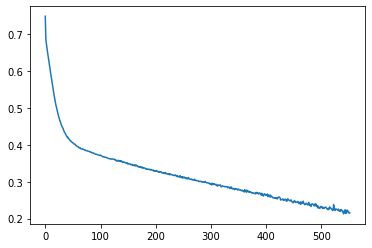

In [72]:
pd.Series(results['model_object'][7].loss_curve_).plot()

In [15]:
coefs = pd.DataFrame({
    'features': num_cols + bool_cols + list(ct.transformers_[2][1]['ohe'].get_feature_names()),
    'coef': models['logistic_regression_base']['model'].coef_.ravel()
})


coefs['coef_abs'] = coefs['coef'].abs()
coefs.sort_values(by='coef_abs', ascending=False)

,features,coef,coef_abs
1,red_str,-2.446643,2.446643
0,blue_str,2.412389,2.412389
6,blue_pass,0.655575,0.655575
31,red_last_fight_win,-0.625656,0.625656
33,red_last_fight_loss,-0.617063,0.617063
30,blue_last_fight_win,0.533255,0.533255
32,blue_last_fight_loss,0.498338,0.498338
5,red_sub,-0.489480,0.489480
7,red_pass,-0.471983,0.471983
4,blue_sub,0.436000,0.436000


In [16]:
df_long.query('name == "Conor McGregor"').sort_values(by=['name', 'date'])

,event_name,fight_id,date,weight_class,win_method,win_round,win_time,name,fighter_url,colour,str,td,sub,pass,winner,loser,blue_win,win_method_bin,num_fights,wins,losses,days_since_last_fight,total_tko_recieved,fight_time,total_octagon_time,last_fight_time,last_fight_tko_received,last_fight_win,last_fight_loss,height_inches,weight_lbs,reach_inches,stance
2034,UFC_on_FUEL_TV-Mousasi_vs_Latifi,3345,2013-04-06,Featherweight,"KO/TKO, Punches",1,1:07,Conor McGregor,http://www.ufcstats.com/fighter-details/f4c499...,blue,21.0,0.0,0.0,0.0,1,0,1,TKO,0,0,0,0.0,0,1.000000,0.000000,0.000000,0,0,0,69.0,155.0,74.0,Southpaw
2035,UFC_Fight_Night-Shogun_vs_Sonnen,3212,2013-08-17,Featherweight,U-DEC,3,5:00,Conor McGregor,http://www.ufcstats.com/fighter-details/f4c499...,red,53.0,4.0,0.0,6.0,1,0,0,DEC,1,1,0,133.0,0,15.000000,1.000000,1.000000,0,1,0,69.0,155.0,74.0,Southpaw
2036,UFC_Fight_Night-McGregor_vs_Brandao,2758,2014-07-19,Featherweight,"KO/TKO, Punch",1,4:05,Conor McGregor,http://www.ufcstats.com/fighter-details/f4c499...,red,18.0,1.0,0.0,1.0,1,0,0,TKO,2,2,0,336.0,0,4.000000,16.000000,15.000000,0,1,0,69.0,155.0,74.0,Southpaw
2037,UFC_178-Johnson_vs_Cariaso,2666,2014-09-27,Featherweight,"KO/TKO, Punch",1,1:46,Conor McGregor,http://www.ufcstats.com/fighter-details/f4c499...,red,9.0,0.0,0.0,0.0,1,0,0,TKO,3,3,0,70.0,0,1.066667,20.000000,4.000000,0,1,0,69.0,155.0,74.0,Southpaw
2038,UFC_Fight_Night-McGregor_vs_Siver,2517,2015-01-18,Featherweight,"KO/TKO, Punch",2,1:54,Conor McGregor,http://www.ufcstats.com/fighter-details/f4c499...,blue,64.0,0.0,0.0,1.0,1,0,1,TKO,4,4,0,113.0,0,6.083333,21.066667,1.066667,0,1,0,69.0,155.0,74.0,Southpaw
2039,UFC_189-Mendes_vs_McGregor,2292,2015-07-11,Featherweight,"KO/TKO, Punch",2,4:57,Conor McGregor,http://www.ufcstats.com/fighter-details/f4c499...,blue,46.0,0.0,0.0,0.0,1,0,1,TKO,5,5,0,174.0,0,9.083333,27.150000,6.083333,0,1,0,69.0,155.0,74.0,Southpaw
2040,UFC_194-Aldo_vs_McGregor,2080,2015-12-12,Featherweight,"KO/TKO, Punch",1,0:13,Conor McGregor,http://www.ufcstats.com/fighter-details/f4c499...,red,5.0,0.0,0.0,0.0,1,0,0,TKO,6,6,0,154.0,0,0.016667,36.233333,9.083333,0,1,0,69.0,155.0,74.0,Southpaw
2041,UFC_196-McGregor_vs_Diaz,1979,2016-03-05,Welterweight,"SUB, Rear, Naked, Choke",2,4:12,Conor McGregor,http://www.ufcstats.com/fighter-details/f4c499...,blue,61.0,0.0,0.0,0.0,0,1,0,SUB,7,7,0,84.0,0,9.016667,36.250000,0.016667,0,1,0,69.0,155.0,74.0,Southpaw
2042,UFC_202-Diaz_vs_McGregor_2,1774,2016-08-20,Welterweight,M-DEC,5,5:00,Conor McGregor,http://www.ufcstats.com/fighter-details/f4c499...,blue,164.0,0.0,0.0,0.0,1,0,1,DEC,8,7,1,168.0,0,25.000000,45.266667,9.016667,0,0,1,69.0,155.0,74.0,Southpaw
2043,UFC_205-Alvarez_vs_McGregor,1671,2016-11-12,Lightweight,"KO/TKO, Punches",2,3:04,Conor McGregor,http://www.ufcstats.com/fighter-details/f4c499...,blue,32.0,0.0,0.0,0.0,1,0,1,TKO,9,8,1,84.0,0,8.000000,70.266667,25.000000,0,1,0,69.0,155.0,74.0,Southpaw


In [17]:
X

,event_name,date,weight_class,win_method,win_round,win_time,fight_url,fight_id,blue,red,winner_colour,blue_url,red_url,winner_name,blue_str,red_str,blue_td,red_td,blue_sub,red_sub,blue_pass,red_pass,win_method_bin,blue_num_fights,blue_wins,blue_losses,blue_days_since_last_fight,blue_total_tko_recieved,blue_total_octagon_time,blue_last_fight_time,blue_last_fight_tko_received,blue_last_fight_win,blue_last_fight_loss,blue_height_inches,blue_weight_lbs,blue_reach_inches,blue_stance,red_num_fights,red_wins,red_losses,red_days_since_last_fight,red_total_tko_recieved,red_total_octagon_time,red_last_fight_time,red_last_fight_tko_received,red_last_fight_win,red_last_fight_loss,red_height_inches,red_weight_lbs,red_reach_inches,red_stance
0,UFC_Fight_Night-Overeem_vs_Harris,2020-05-16,Heavyweight,"KO/TKO, Punches",2,3:00,http://www.ufcstats.com/fight-details/ce074851...,0,Alistair Overeem,Walt Harris,blue,http://www.ufcstats.com/fighter-details/b4ad3a...,http://www.ufcstats.com/fighter-details/03f982...,Alistair Overeem,68.0,25.0,1.0,0.0,0.0,0.0,3.0,0.0,TKO,17,10,7,161.0,7,142.616667,24.083333,1,0,1,76.0,265.0,80.0,Orthodox,13,6,7,301.0,2,80.466667,0.016667,0,1,0,77.0,250.0,77.0,Southpaw
1,UFC_Fight_Night-Overeem_vs_Harris,2020-05-16,Women's Strawweight,S-DEC,3,5:00,http://www.ufcstats.com/fight-details/27bfb920...,1,Angela Hill,Claudia Gadelha,red,http://www.ufcstats.com/fighter-details/f0feeb...,http://www.ufcstats.com/fighter-details/ec3434...,Claudia Gadelha,90.0,84.0,0.0,1.0,0.0,0.0,0.0,1.0,DEC,14,7,7,84.0,0,176.216667,15.000000,0,1,0,63.0,115.0,64.0,Orthodox,10,6,4,315.0,0,148.000000,15.000000,0,1,0,64.0,115.0,63.0,Orthodox
2,UFC_Fight_Night-Overeem_vs_Harris,2020-05-16,Featherweight,S-DEC,3,5:00,http://www.ufcstats.com/fight-details/58540b24...,2,Edson Barboza,Dan Ige,red,http://www.ufcstats.com/fighter-details/64a50d...,http://www.ufcstats.com/fighter-details/82a515...,Dan Ige,80.0,79.0,0.0,1.0,0.0,0.0,0.0,0.0,DEC,22,14,8,252.0,3,240.416667,15.000000,0,0,1,71.0,145.0,75.0,Orthodox,6,5,1,98.0,0,61.100000,15.000000,0,1,0,67.0,145.0,71.0,Orthodox
3,UFC_Fight_Night-Overeem_vs_Harris,2020-05-16,Middleweight,U-DEC,3,5:00,http://www.ufcstats.com/fight-details/821a1c6f...,3,Krzysztof Jotko,Eryk Anders,blue,http://www.ufcstats.com/fighter-details/4e0691...,http://www.ufcstats.com/fighter-details/cad244...,Krzysztof Jotko,66.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,DEC,12,8,4,294.0,2,148.216667,15.000000,0,1,0,73.0,185.0,77.0,Southpaw,9,5,4,217.0,1,117.166667,15.000000,0,1,0,73.0,185.0,75.0,Southpaw
4,UFC_Fight_Night-Overeem_vs_Harris,2020-05-16,Featherweight,U-DEC,3,5:00,http://www.ufcstats.com/fight-details/81f2f2d4...,4,Marlon Vera,Song Yadong,red,http://www.ufcstats.com/fighter-details/7c7332...,http://www.ufcstats.com/fighter-details/efb96b...,Song Yadong,92.0,101.0,2.0,0.0,0.0,0.0,1.0,0.0,DEC,13,9,4,217.0,0,134.333333,13.016667,0,1,0,68.0,145.0,70.0,Switch,5,4,1,161.0,0,45.100000,15.000000,0,0,1,68.0,145.0,67.0,Orthodox
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5591,UFC_1-The_Beginning,1993-11-12,Open Weight,KO/TKO,1,0:59,http://www.ufcstats.com/fight-details/ac7ca2ec...,5591,Kevin Rosier,Gerard Gordeau,red,http://www.ufcstats.com/fighter-details/598a58...,http://www.ufcstats.com/fighter-details/279093...,Gerard Gordeau,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,TKO,0,0,0,0.0,0,0.000000,0.000000,0,0,0,76.0,275.0,NaN,Orthodox,1,0,1,0.0,0,1.066667,1.066667,0,0,1,77.0,216.0,NaN,Orthodox
5592,UFC_1-The_Beginning,1993-11-12,Open Weight,"SUB, Heel, Hook",1,1:49,http://www.ufcstats.com/fight-details/46acd54c...,5592,Patrick Smith,Ken Shamrock,red,http://www.ufcstats.com/fighter-details/46c8ec...,http://www.ufcstats.com/fighter-details/63b65a...,Ken Shamrock,4.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,SUB,0,0,0,0.0,0,0.000000,0.000000,0,0,0,74.0,225.0,NaN,Orthodox,1,0,1,0.0,0,0.083333,0.083333,0,0,1,73.0,205.0